# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
## Felipe Rojas Leon
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [55]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


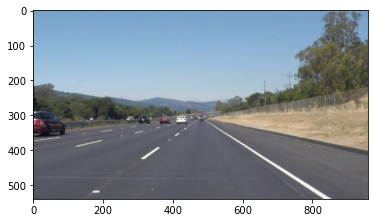

In [56]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [57]:
import math

################################################################################    
################## SELF DRIVING CAR ENGINEER NANO DEGREE #######################
################################################################################

##### Project one: Computer vision. Detecting the lanes of a road
##### by Felipe Rojas\
##### In this project, you will use the tools you learned about in the lesson 
##### to identify lane lines on the road.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2 ## OPEN CV library

def gray_scale(img):
    #Transform the Color 3D image into gray scale 2D image
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size = 5):
    #We Use the blur the remove non linearities in the image
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    #We use canny for Edge detection in our image
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interst(img, vertices):
    # Build a mask of desired shape and size for of region of interest
    mask = np.zeros_like(img)
    
    if len(img.shape)>2:
        channel_count = img.shape[2]
        ignore_mask_color = (255, ) * channel_count
        
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #plt.imshow(mask, cmap = 'gray')
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, selector, rho, theta, threshold, min_line_len, max_line_gap):
    # We need a Canny image as input
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, 
                            maxLineGap = max_line_gap)
    img_lines = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    "Selector: 0  for detecting broken lines in a road and 1 for drawing the line over the road"
    if(selector == 0):
        draw_lines(img_lines, lines)
    else:
        draw_lanes(img_lines, lines)
        
    return img_lines


def draw_lines(img, lines, color=[255, 0,0], thickness = 10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color, thickness)
       
            
       
def draw_lanes(img, lines, color=[0, 0,255], thickness = 12):
    
    m = 0
    b = 0
    #variables for the left lane
    m_added_left = 0
    b_added_left = 0
    left_counter = 0
    global last_left_m
    global last_left_b
    #variables for the right lane
    m_added_right = 0
    b_added_right = 0
    right_counter = 0
    global last_right_m
    global last_right_b
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #Calculate the slope to know if the lane corresponds to left lane or right lane
            #Positive slope corresponds to right lane and negative slope corresponds to left lane
            m = (y2-y1)/(x2-x1)
            b = y2 - (m*x2)
            
            if m<0:
                m_added_left += m
                b_added_left += b
                left_counter += 1
                       
            else:
                m_added_right += m
                b_added_right += b
                right_counter += 1
                
    # Calculate the average slope and points for EACH LANE
    #LEFT LANE
    #There are cases when NO lines are detected so the counter is 0. We have to make sure
    #that we dont divide by 0 and also, we always draw a lane
    
    #Ocassionally, the edge detection will detect lines other than the road lines.
    #By creating global average slope variables the variance of the slope will be
    #almost regular in all iterations
    global average_left_m
    global average_left_b
    global average_right_m
    global average_right_b

    if left_counter != 0:
        average_left_m = (m_added_left/left_counter)
        average_left_b = (b_added_left/left_counter)
        last_left_m = average_left_m
        last_left_b = average_left_b
    else:
        average_left_m = last_left_m
        average_left_b = last_left_b
    
    
    imshape = img.shape

    Y_bottom = int(imshape[0])
    Y_top = int(imshape[0]*0.63)
    X_bottom = (Y_bottom - average_left_b)/average_left_m
    X_top = (Y_top - average_left_b)/average_left_m
    if((X_bottom>= 0) and (X_bottom<= 960) and ((X_top>= 0) and (X_top<= 960))):
        cv2.line(img,(int(X_bottom),Y_bottom),(int(X_top),Y_top),color, thickness)     

    #RIGHT LANE     
    if right_counter != 0:
        average_right_m = m_added_right/right_counter
        average_right_b = b_added_right/right_counter
        last_right_m = average_right_m
        last_right_b = average_right_b
    else:
        average_right_m = last_right_m
        average_right_b = last_right_b
         
    X_bottom = (Y_bottom - average_right_b)/average_right_m
    X_top = (Y_top - average_right_b)/average_right_m
    if((X_bottom>= 0) and (X_bottom<= 960) and ((X_top>= 0) and (X_top<= 960))):
        cv2.line(img,(int(X_bottom),Y_bottom),(int(X_top),Y_top),color, thickness) 
              

def add_weighted(img, color_image, alpha = 0.8, beta = 1):
    #we draw the lines that we found over the original image
    return cv2.addWeighted(color_image, alpha, img, beta, 0)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [58]:
import os
image_list = os.listdir("test_images/")
for image in image_list:
    print('test_images/'+str(image))

test_images/challenge.png
test_images/solidWhiteCurve.jpg
test_images/solidWhiteCurve_lanedetection.png
test_images/solidWhiteCurve_raw.png
test_images/solidWhiteRight.jpg
test_images/solidWhiteRight_lanedetection.png
test_images/solidWhiteRight_raw.png
test_images/solidYellowCurve.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowCurve2_lanedetection.png
test_images/solidYellowCurve2_raw.png
test_images/solidYellowCurve_lanedetection.png
test_images/solidYellowCurve_raw.png
test_images/solidYellowLeft.jpg
test_images/solidYellowLeft_lanedetection.png
test_images/solidYellowLeft_raw.png
test_images/whiteCarLaneSwitch.jpg
test_images/whiteCarLaneSwitch_lanedetection.png
test_images/whiteCarLaneSwitch_raw.png


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [59]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# Function that follows step by step the lane detection method
# Function that follows step by step the lane detection method
def lane_detection_raw(img, selector=0):
    #Create a copy of the original image
    color_image = np.copy(img)
    #First, we transform the color image to a 2D gray scale image
    gray = gray_scale(img)
    plt.imshow(gray, cmap = 'gray')
    #Then, we apply Gaussian bluring to the image
    blur_image = gaussian_blur(gray, 7)
    plt.imshow(blur_image, cmap = 'gray')
    #Now we use the Canny method for Edge detection
    canny_image = canny(blur_image, 50, 150)
    plt.imshow(canny_image, cmap = 'gray')
    
    #We define the vertices for our Area of Interest Polygon
    '''vertices = np.array([[(48, 540),    #bottom left vertice
                          (436, 337),   #top left vertice
                          (533, 337),   #top right vertice
                          (955,540)]])  #bottom right vertice'''
    
    #Using percentages for different size images
    imshape = img.shape
    vertices = np.array([[(int(imshape[1]*0.05), int(imshape[0]*0.92)),     #bottom left vertice (X, Y)
                          (int(imshape[1]*0.47), int(imshape[0]*0.60)),     #top left vertice 
                          (int(imshape[1]*0.47), int(imshape[0]*0.60)),     #top right vertice
                          (int(imshape[1]*0.99), int(imshape[0]*0.92))]])   #bottom right vertice   
    #Ignore everything but the Area of interest in our Canny image
    masked_image = region_of_interst(canny_image, vertices)
    
    
    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 35 #minimum number of pixels making up a line
    max_line_gap = 5  # maximum gap in pixels between connectable line segments
    
    #Identify and draw the lines
    lines = hough_lines(masked_image, selector, rho, theta, threshold, min_line_length,  
                        max_line_gap)
    lanes_image = add_weighted(lines, color_image, 0.8, 1)
    plt.imshow(lanes_image)
    return lanes_image

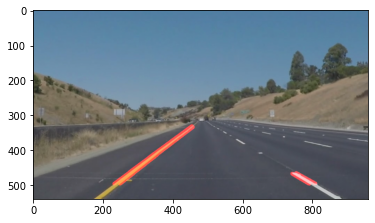

In [60]:
################################################################################    
########### Testing the Lane detection function for Broken lines ###############
################################################################################

image1 = mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(image1)
image1_broken_lines = lane_detection_raw(image1, 0)
plt.imshow(image1_broken_lines)
#mpimg.imsave("test_images/solidWhiteCurve_raw.png", image1_broken_lines)

image2 = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image2)
image2_broken_lines = lane_detection_raw(image2, 0)
#mpimg.imsave("test_images/solidWhiteRight_raw.png", image2_broken_lines)

image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
plt.imshow(image3)
image3_broken_lines = lane_detection_raw(image3, 0)
#mpimg.imsave("test_images/solidYellowCurve_raw.png", image3_broken_lines)

image4 = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(image4)
image4_broken_lines = lane_detection_raw(image4, 0)
#mpimg.imsave("test_images/solidYellowCurve2_raw.png", image4_broken_lines)


image5 = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(image5)
image5_broken_lines = lane_detection_raw(image5, 0)
#mpimg.imsave("test_images/solidYellowLeft_raw.png", image5_broken_lines)


image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(image6)
image6_broken_lines = lane_detection_raw(image6, 0)
#mpimg.imsave("test_images/whiteCarLaneSwitch_raw.png", image6_broken_lines)




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

                                                              
t:  44%|████▍     | 111/251 [1:10:48<00:08, 16.50it/s, now=None]
                                                                
t:  44%|████▍     | 111/251 [1:09:39<00:11, 12.21it/s, now=None]

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight_raw.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight_raw.mp4





t:   1%|▏         | 3/221 [00:00<00:08, 24.86it/s, now=None]

t:   3%|▎         | 7/221 [00:00<00:08, 26.58it/s, now=None]

t:   5%|▍         | 11/221 [00:00<00:07, 28.17it/s, now=None]

t:   7%|▋         | 15/221 [00:00<00:07, 29.33it/s, now=None]

t:   9%|▊         | 19/221 [00:00<00:06, 30.87it/s, now=None]

t:  10%|█         | 23/221 [00:00<00:06, 32.67it/s, now=None]

t:  12%|█▏        | 27/221 [00:00<00:05, 32.98it/s, now=None]

t:  14%|█▍        | 31/221 [00:00<00:05, 33.07it/s, now=None]

t:  16%|█▌        | 35/221 [00:01<00:05, 33.63it/s, now=None]

t:  18%|█▊        | 39/221 [00:01<00:05, 34.52it/s, now=None]

t:  19%|█▉        | 43/221 [00:01<00:05, 34.90it/s, now=None]

t:  21%|██▏       | 47/221 [00:01<00:05, 33.66it/s, now=None]

t:  23%|██▎       | 51/221 [00:01<00:05, 32.85it/s, now=None]

t:  25%|██▍       | 55/221 [00:01<00:05, 31.84it/s, now=None]

t:  27%|██▋       | 59/221 [00:01<00:05, 31.02it/s, now=None]

t:  29%|██▊       | 63/221 [00:01<00:05, 30.00it/s, now

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight_raw.mp4


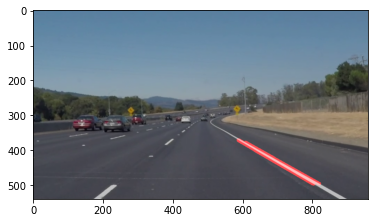

In [62]:
################# Using the Lane detection function for videos #################

from moviepy.editor import VideoFileClip

white_output_raw = 'test_videos_output/solidWhiteRight_raw.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_detection_raw) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output_raw, audio=False)


Play the video online, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_raw))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [65]:
# Function that follows step by step the lane detection method
def lane_detection(img, selector=1):
    #Create a copy of the original image
    color_image = np.copy(img)
    #First, we transform the color image to a 2D gray scale image
    gray = gray_scale(img)
    plt.imshow(gray, cmap = 'gray')
    #Then, we apply Gaussian bluring to the image
    blur_image = gaussian_blur(gray, 7)
    plt.imshow(blur_image, cmap = 'gray')
    #Now we use the Canny method for Edge detection
    canny_image = canny(blur_image, 50, 150)
    plt.imshow(canny_image, cmap = 'gray')
    
    #We define the vertices for our Area of Interest Polygon
    '''vertices = np.array([[(48, 540),    #bottom left vertice
                          (436, 337),   #top left vertice
                          (533, 337),   #top right vertice
                          (955,540)]])  #bottom right vertice'''
    imshape = img.shape
    vertices = np.array([[(int(imshape[1]*0.05), int(imshape[0]*0.92)),     #bottom left vertice (X, Y)
                          (int(imshape[1]*0.47), int(imshape[0]*0.60)),     #top left vertice 
                          (int(imshape[1]*0.47), int(imshape[0]*0.60)),     #top right vertice
                          (int(imshape[1]*0.99), int(imshape[0]*0.92))]])   #bottom right vertice   
    
    #Ignore everything but the Area of interest in our Canny image
    masked_image = region_of_interst(canny_image, vertices)
    
    
    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 35 #minimum number of pixels making up a line
    max_line_gap = 5  # maximum gap in pixels between connectable line segments
    
    #Identify and draw the lines
    lines = hough_lines(masked_image, selector, rho, theta, threshold, min_line_length,  
                        max_line_gap)
    lanes_image = add_weighted(lines, color_image, 0.8, 1)
    plt.imshow(lanes_image)
    return lanes_image

Now for the one with the solid yellow lane on the left. This one's more tricky!

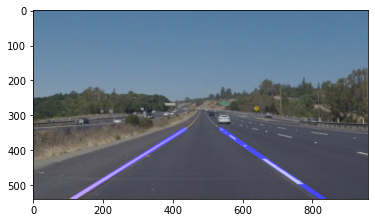

In [69]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(lane_detection) #NOTE: this function expects color images!!
#%time yellow_clip.write_videofile(yellow_output, audio=False)

In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

                                                                
t:  44%|████▍     | 111/251 [1:17:56<00:08, 16.50it/s, now=None]
                                                                
t:  44%|████▍     | 111/251 [1:16:47<00:11, 12.21it/s, now=None]

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

t:   1%|          | 2/251 [00:00<00:17, 14.49it/s, now=None]

Moviepy - Building video test_videos_output/challenge_raw.mp4.
Moviepy - Writing video test_videos_output/challenge_raw.mp4





t:   1%|          | 3/251 [00:00<00:28,  8.73it/s, now=None]

t:   2%|▏         | 6/251 [00:00<00:22, 10.72it/s, now=None]

t:   4%|▎         | 9/251 [00:00<00:18, 12.76it/s, now=None]

t:   5%|▍         | 12/251 [00:00<00:16, 14.76it/s, now=None]

t:   6%|▌         | 15/251 [00:00<00:14, 16.51it/s, now=None]

t:   7%|▋         | 18/251 [00:01<00:12, 18.06it/s, now=None]

t:   8%|▊         | 21/251 [00:01<00:12, 19.02it/s, now=None]

t:  10%|▉         | 24/251 [00:01<00:11, 19.89it/s, now=None]

t:  11%|█         | 27/251 [00:01<00:10, 20.55it/s, now=None]

t:  12%|█▏        | 30/251 [00:01<00:10, 21.26it/s, now=None]

t:  13%|█▎        | 33/251 [00:01<00:10, 21.15it/s, now=None]

t:  14%|█▍        | 36/251 [00:01<00:10, 21.11it/s, now=None]

t:  16%|█▌        | 39/251 [00:01<00:10, 20.32it/s, now=None]

t:  17%|█▋        | 42/251 [00:02<00:10, 20.32it/s, now=None]

t:  18%|█▊        | 45/251 [00:02<00:10, 19.45it/s, now=None]

t:  19%|█▊        | 47/251 [00:02<00:10, 18.91it/s, now=

t: 100%|██████████| 251/251 [00:15<00:00, 10.50it/s, now=None]

                                                              
                                                                
t:  44%|████▍     | 111/251 [1:18:13<00:08, 16.50it/s, now=None]
                                                                
t:  44%|████▍     | 111/251 [1:18:13<00:08, 16.50it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_raw.mp4


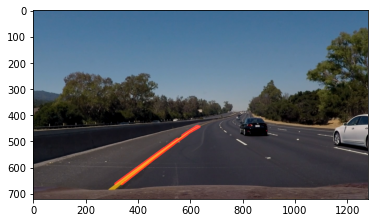

In [70]:
############################## C H A L L E N G E ##############################
challenge_output = 'test_videos_output/challenge_raw.mp4'
#clip3 = VideoFileClip("test_videos/challenge.mp4").subclip(0,2)
clip3 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(lane_detection_raw) #NOTE: this function expects color images!!
challenge_clip.write_videofile(challenge_output, audio=False)



In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))


                                                                
t:  44%|████▍     | 111/251 [1:19:45<00:08, 16.50it/s, now=None]
                                                                
t:  44%|████▍     | 111/251 [1:19:45<00:08, 16.50it/s, now=None]

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

t:   1%|          | 2/251 [00:00<00:12, 19.65it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4





t:   2%|▏         | 5/251 [00:00<00:12, 19.99it/s, now=None]

t:   3%|▎         | 7/251 [00:00<00:12, 19.31it/s, now=None]

t:   4%|▎         | 9/251 [00:00<00:13, 18.15it/s, now=None]

t:   4%|▍         | 11/251 [00:00<00:13, 17.37it/s, now=None]

t:   5%|▌         | 13/251 [00:00<00:21, 11.17it/s, now=None]

t:   6%|▌         | 15/251 [00:01<00:20, 11.77it/s, now=None]

t:   7%|▋         | 17/251 [00:01<00:17, 13.22it/s, now=None]

t:   8%|▊         | 20/251 [00:01<00:15, 14.95it/s, now=None]

t:   9%|▉         | 23/251 [00:01<00:13, 16.34it/s, now=None]

t:  10%|▉         | 25/251 [00:01<00:21, 10.69it/s, now=None]

t:  11%|█         | 27/251 [00:03<00:54,  4.12it/s, now=None]

t:  12%|█▏        | 29/251 [00:03<00:43,  5.16it/s, now=None]

t:  12%|█▏        | 31/251 [00:04<01:00,  3.61it/s, now=None]

t:  13%|█▎        | 33/251 [00:04<00:45,  4.76it/s, now=None]

t:  14%|█▍        | 35/251 [00:04<00:35,  6.17it/s, now=None]

t:  15%|█▍        | 37/251 [00:04<00:28,  7.49it/s, now=

t:  97%|█████████▋| 243/251 [00:17<00:00, 15.62it/s, now=None]

t:  98%|█████████▊| 245/251 [00:18<00:00, 15.89it/s, now=None]

t:  98%|█████████▊| 247/251 [00:18<00:00, 15.86it/s, now=None]

t:  99%|█████████▉| 249/251 [00:18<00:00, 16.01it/s, now=None]

t: 100%|██████████| 251/251 [00:18<00:00, 15.79it/s, now=None]

                                                              
                                                                
t:  44%|████▍     | 111/251 [1:20:05<00:08, 16.50it/s, now=None]
                                                                
t:  44%|████▍     | 111/251 [1:20:05<00:08, 16.50it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4


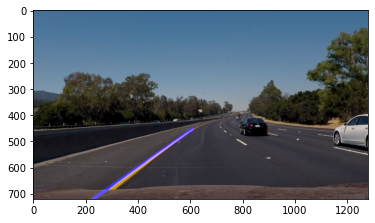

In [72]:
############################## C H A L L E N G E ##############################
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(lane_detection) #NOTE: this function expects color images!!
challenge_clip.write_videofile(challenge_output, audio=False)

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))